In [1]:
import sys
import time
import copy

from itertools import repeat
import data, data.gene_datasets
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import gene_inference
#from gene_inference.infer_genes import infer_all_genes, sample_neighbors
import models, models.graphLayer
from models.models import CGN
import data, data.gene_datasets
from data.graph import Graph
from data.utils import split_dataset
import optimization
import torch
from torch.autograd import Variable
from analysis.metrics import record_metrics_for_epoch
import analysis
reload(analysis.metrics)
reload(gene_inference);

/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')
#tcgatissue = data.gene_datasets.TCGATissue()

Converting one-hot labels to integers


In [3]:
class Object(object):
    pass

opt = Object()
opt.seed = 0
opt.nb_class = None
opt.nb_examples = None
opt.nb_nodes = None
opt.graph = "pathway"
opt.dataset = tcgatissue
opt.add_self = True
opt.norm_adj = True
opt.add_connectivity = False
opt.num_layer = 1
opt.cuda = True
opt.pool_graph = "ignore"


In [4]:
graph = Graph()
#path = "/data/lisa/data/genomics/graph/pancan-tissue-graph.hdf5"
path = "genomics/graph/pancan-tissue-graph.hdf5"
graph.load_graph(path)
#graph.intersection_with(tcgatissue)
g = nx.from_numpy_matrix(graph.adj)
mapping = dict(zip(range(0, len(tcgatissue.df.columns)), tcgatissue.df.columns))
g = nx.relabel_nodes(g, mapping)

In [5]:
def sample_neighbors(g, gene, num_neighbors, include_self=True):
    results = set([])
    if include_self:
        results = set([gene])
    all_nodes = set(g.nodes)
    first_degree = set(g.neighbors(gene))
    second_degree = set()
    for x in g.neighbors(gene):
        second_degree = second_degree.union(set(g.neighbors(x)))
    while len(results) < num_neighbors:
        if len(first_degree) - len(results) > 0:
            unique = sorted(first_degree - results)
            results.add(unique.pop())
        elif len(second_degree) - len(results) > 0:
            unique = sorted(second_degree - results)
            results.add(unique.pop())
        else:
            unique = sorted(all_nodes - results)
            results.add(unique.pop())
    return results

In [6]:
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np

class Method:
    def __init__(self):
        pass

class SkLearn(Method):
    
    def __init__(self, model, penalty=False):
        self.model = model
        self.penalty = penalty
        
    def loop(self, dataset, seed, train_size, test_size, adj=None):
        
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)

        if self.model == "LR":
            model = sklearn.linear_model.LogisticRegression()
            if self.penalty:
                model = sklearn.linear_model.LogisticRegression(penalty='l1', tol=0.0001)
        elif self.model == "DT":
            model = sklearn.tree.DecisionTreeClassifier()
        elif self.model == "MLP":
            model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(32,3), learning_rate_init=0.001, early_stopping=False,  max_iter=1000)
        else:
            print "incorrect label"
        
        model = model.fit(X_train, y_train)
        return sklearn.metrics.roc_auc_score(y_test, model.predict(X_test))


class PyTorch(Method):    
    
    def __init__(self, model, num_epochs=100, num_channel=16, num_layer=2, add_emb=8, use_gate=False, dropout=False, cuda=False):
        self.model = model
        self.batch_size = 10
        self.num_channel = num_channel
        self.num_layer = num_layer
        self.add_emb = add_emb
        self.use_gate = use_gate
        self.dropout = dropout
        self.cuda = cuda
        self.num_epochs = num_epochs
        self.patience = 10
        self.attention_head = 0
        
    def loop(self, dataset, seed, train_size, test_size, adj=None):
    
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)
    
        #split train into valid and train
        if len(set(y_train)) == 1 or len(set(y_test)) == 1: 
            return
        try:
            local_X_train, local_X_valid, local_y_train, local_y_valid = sklearn.model_selection.train_test_split(X_train, y_train, stratify=y_train, train_size=0.60, random_state=seed)
        except Exception:
            return
        local_X_train = torch.FloatTensor(np.expand_dims(local_X_train, axis=2))
        local_X_valid = torch.FloatTensor(np.expand_dims(local_X_valid, axis=2))
        X_test = torch.FloatTensor(np.expand_dims(X_test, axis=2))
        
        local_y_train = torch.FloatTensor(local_y_train)

        criterion = optimization.get_criterion(dataset)
        patience = self.patience
        opt.num_layer = self.num_layer
        adj_transform, aggregate_function = models.graphLayer.get_transform(opt, adj)

        if self.model == "CGN":
            model = models.models.CGN(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1,
                    channels=[self.num_channel] * self.num_layer,
                    adj=adj,
                    out_dim=2,
                    on_cuda=self.cuda,
                    add_emb=self.add_emb,
                    transform_adj=adj_transform,
                    aggregate_adj=aggregate_function,
                    use_gate=self.use_gate,
                    dropout=self.dropout,
                    attention_head=self.attention_head
                    )
        elif self.model == "MLP":
            model = models.models.MLP(
                    len(dataset.df.columns), 
                    channels=[self.num_channel] * self.num_layer, 
                    out_dim=2, 
                    on_cuda=self.cuda, 
                    dropout=self.dropout)
        elif self.model == "SLR":
            model = models.models.SparseLogisticRegression(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1, 
                    adj=adj, 
                    out_dim=2, 
                    on_cuda=self.cuda)
        elif self.model == "LCG":
            model = models.models.LCG(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1, 
                    channels=[self.num_channel] * self.num_layer,
                    adj=adj, 
                    out_dim=2,
                    on_cuda=self.cuda,
                    add_emb=self.add_emb,
                    transform_adj=adj_transform, 
                    aggregate_adj=aggregate_function, 
                    use_gate=self.use_gate,
                    dropout=self.dropout,
                    attention_head=nb_attention_head, 
                    training_mode=training_mode)
        elif self.model == 'LR':
            model = models.models.LogisticRegression(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1, 
                    out_dim=2,
                    on_cuda=self.cuda)
            
        if self.cuda:
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            model.cuda()

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
        max_valid = 0
        max_valid_test = 0
        for t in range(0, self.num_epochs):
            start_timer = time.time()
            
            for base_x in range(0,local_X_train.shape[0], self.batch_size):
                inputs, labels = local_X_train[base_x:base_x+self.batch_size], local_y_train[base_x:base_x+self.batch_size]

                inputs = Variable(inputs, requires_grad=False).float()
                if self.cuda:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                model.train()
                y_pred = model(inputs)

                # Compute and print loss
                crit_loss = optimization.compute_loss(criterion, y_pred, labels)
                total_loss = crit_loss

                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad()
                crit_loss.backward()
                optimizer.step()
                model.eval()

            auc = {'train': 0., 'valid': 0., 'test': 0.}
            res = []
            try:
                for base_x in range(0,local_X_train.shape[0], self.batch_size):
                    inputs = Variable(local_X_train[base_x:base_x+self.batch_size], requires_grad=False).float()
                    res.append(model(inputs)[:,1].data.cpu().numpy())
                auc['train'] = sklearn.metrics.roc_auc_score(local_y_train.numpy(), np.asarray(res).flatten())

                res = []
                for base_x in range(0,local_X_valid.shape[0], self.batch_size):
                    inputs = Variable(local_X_valid[base_x:base_x+self.batch_size], requires_grad=False).float()
                    res.append(model(inputs)[:,1].data.cpu().numpy())
                auc['valid'] = sklearn.metrics.roc_auc_score(local_y_valid, np.asarray(res).flatten())

                res = []
                for base_x in range(0,X_test.shape[0], self.batch_size):
                    inputs = Variable(X_test[base_x:base_x+self.batch_size], requires_grad=False).float()
                    res.append(model(inputs)[:,1].data.cpu().numpy())
                auc['test'] = sklearn.metrics.roc_auc_score(y_test, np.asarray(res).flatten())
            except Exception:
                pass
            
            time_this_epoch = time.time() - start_timer

#eval on cpu
#             auc['train'] = sklearn.metrics.roc_auc_score(local_y_train.numpy(), model(Variable(local_X_train.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
#             auc['valid'] = sklearn.metrics.roc_auc_score(local_y_valid, model(Variable(local_X_valid.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
#             auc['test'] = sklearn.metrics.roc_auc_score(y_test, model(Variable(X_test.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
            
            summary = [ t, crit_loss.data[0], auc['train'], auc['valid'], time_this_epoch ]
            summary = "epoch {}, cross_loss: {:.03f}, auc_train: {:0.3f}, auc_valid:{:0.3f}, time: {:.02f} sec".format(*summary)
            #print summary

            patience = patience - 1
            if patience == 0:
                return max_valid_test
                break
            if (max_valid < auc['valid']) and t > 5:
                max_valid = auc['valid']
                max_valid_test = auc['test']
                patience = self.patience

In [7]:
def method_comparison(results, dataset, models, gene, num_genes, trials, train_size, test_size):
    dataset.df = dataset.df[:1500]
    mean = dataset.df[gene].mean()
    dataset.labels = [1 if x > mean else 0 for x in dataset.df[gene]]
    neighbors = sample_neighbors(g, gene, num_genes, include_self=True)
    #print "neighbors", len(neighbors)

#             if gene in neighbors:
#                 neighbors.remove(gene)

    dataset.df = dataset.df[list(neighbors)]
    dataset.df[gene] = 1
    dataset.data = dataset.df.as_matrix()

    neighborhood = np.asarray(nx.to_numpy_matrix(nx.Graph(g.subgraph(neighbors))))
    for model in models:
        for seed in range(trials):

            #have we already done it?
            already_done = results["df"][(results["df"].gene_name == gene) & 
                                         (results["df"].model == model['key']) &
                                         (results["df"].num_genes == num_genes) &
                                         (results["df"].seed == seed) &
                                         (results["df"].train_size == train_size)].shape[0] > 0

            if already_done:
                print "already done:", model['key'], num_genes, seed
                continue
            print "doing:", model['key'], num_genes, seed

            result = model['method'].loop(dataset=dataset, seed=seed, train_size=train_size, test_size=test_size, adj=neighborhood)

            experiment = {"gene_name": gene,
                    "model": model['key'],
                    "num_genes": num_genes, 
                    "seed":seed,
                    "train_size": train_size,
                    "auc":result
                    }

            results["df"] = results["df"].append(experiment, ignore_index=True)
            pickle.dump(results, open("results-temp.pkl", "wb"))
    #dataset.df = full_df


In [8]:
import pickle

m = [
#    {'key': 'LR-L1', 'method': SkLearn("LR", penalty=True)},
#    {'key': 'MLP', 'method': mlp},
#    {'key': 'DT', 'method': SkLearn("DT")},
#    {'key': 'new_CGN_3_layer_64_channel_emb_32_dropout', 'method': PyTorch("CGN")},
# {'key': 'wRPL5_CGN_3_layer_64_channel_emb_32_dropout', 'method': PyTorch("CGN")},
 #{'key': 'wRPL5_CGN_1_layer_32_channel_emb_32_dropout', 'method': PyTorch("CGN", num_layer=1, num_channel=32)},
    #{'key': 'MLP-dropout', 'method': PyTorch("MLP", dropout=True, cuda=False)},
    {'key': 'MLP', 'method': PyTorch("MLP", dropout=False, cuda=False)},
    {'key': 'LR', 'method': PyTorch("LR", dropout=False, cuda=False)},
    
    
#{'key': 'SLR', 'method': PyTorch("SLR")},
#   {'key': 'MLP', 'method': PyTorch("MLP", dropout=False)},
    ]



In [9]:
results = {"df": pd.DataFrame(columns=['auc','gene_name', 'model', 'num_genes', 'seed', 'train_size'])}

In [ ]:
results = pickle.load(open("results-temp.pkl", "r"))

In [ ]:
tcgatissue.df = tcgatissue.df - tcgatissue.df.mean()
full_df = tcgatissue.df.copy(deep=True)
for gene in tcgatissue.df.columns:
    tcgatissue.df = full_df
    method_comparison(results, tcgatissue, m, gene=gene, num_genes=50, trials=5, train_size=50, test_size=1000)

for gene in tcgatissue.df.columns:
    tcgatissue.df = full_df
    method_comparison(results, tcgatissue, m, gene=gene, num_genes=16300, trials=5, train_size=50, test_size=100)


already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already done: MLP 50 4
already done: LR 50 0
already done: LR 50 1
already done: LR 50 2
already done: LR 50 3
already done: LR 50 4
already done: MLP 50 0
already done: MLP 50 1
already done: MLP 50 2
already done: MLP 50 3
already 

/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0


/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:182: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing:

doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing:

doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: 

doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: M

doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: ML

doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP

doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 

doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR

doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: L

doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: 

doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing:

doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing:

doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: 

doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: M

doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: ML

doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP

doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 

doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR

doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: L

doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: 

doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing:

doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2
doing: MLP 50 3
doing: MLP 50 4
doing: LR 50 0
doing: LR 50 1
doing: LR 50 2
doing: LR 50 3
doing: LR 50 4
doing: MLP 50 0
doing: MLP 50 1
doing: MLP 50 2


In [16]:
results

{'df':             auc gene_name model num_genes seed train_size
 0      0.617046    UBE2Q1   MLP        50    0         50
 1      0.650726    UBE2Q1   MLP        50    1         50
 2      0.645186    UBE2Q1   MLP        50    2         50
 3      0.481116    UBE2Q1   MLP        50    3         50
 4      0.613568    UBE2Q1   MLP        50    4         50
 5      0.592901    UBE2Q1    LR        50    0         50
 6      0.489717    UBE2Q1    LR        50    1         50
 7      0.650718    UBE2Q1    LR        50    2         50
 8      0.520235    UBE2Q1    LR        50    3         50
 9      0.538444    UBE2Q1    LR        50    4         50
 10     0.623666     RNF14   MLP        50    0         50
 11     0.740114     RNF14   MLP        50    1         50
 12     0.660298     RNF14   MLP        50    2         50
 13     0.719552     RNF14   MLP        50    3         50
 14     0.803704     RNF14   MLP        50    4         50
 15     0.523984     RNF14    LR        50    0   

None


In [38]:
a.nodes()

AttributeError: 'NoneType' object has no attribute 'nodes'

In [43]:
plt.rcParams['figure.figsize'] = (10, 10)

pos = nx.circular_layout(a)
nx.draw_networkx(a,pos,with_labels=True, width=2)

TypeError: 'NoneType' object is not iterable

In [35]:
import pickle
#pickle.dump(results, open("results2.pkl", "wb"))

In [31]:
#results = pickle.load(open("results.pkl", "r"))

In [84]:
#results["df"] = results["df"].drop(results["df"][results["df"].model == "new_CGN_3_layer_64_channel_emb_32_dropout"].index)

In [12]:
grouped = results["df"].groupby(['gene_name', 'model','train_size','num_genes'])['auc'].agg(['mean','std', 'count'])
grouped

mean       std  count
gene_name model train_size num_genes                           
RPL5      LR    100        500        0.898820  0.007410      2
                500        500        0.930896  0.000393      2
                1000       500        0.951322  0.001632      2
          MLP   100        500        0.911187  0.000687      2
                500        500        0.937170  0.002775      2
                1000       500        0.950999  0.001714      2

In [279]:
#results["df"].groupby(['gene_name', 'model','num_genes'])['auc'].mean().groupby(["model"]).plot(legend=True, sharex=True);

In [13]:
results["df"][results["df"].num_genes==200].groupby(['model','train_size']).agg(['mean','std', 'count'])

Empty DataFrame
Columns: [(auc, mean), (auc, std), (auc, count)]
Index: []

In [14]:
%matplotlib inline
for model in results["df"]["model"].unique():
    q = results["df"][results["df"].num_genes==100].groupby(['model','train_size'])['auc']
    index = q.mean()[model].index
    mean = q.mean()[model]
    stderr = q.std()[model]/np.sqrt(q.count()[model])
    plt.errorbar(index, mean,label=model, xerr=0, yerr=stderr)

plt.title("Gene Inference with varying numbers of nodes")
plt.ylabel("AUC")
plt.xlabel("train_size")
#plt.xscale("log")
plt.xticks(index)
formatter = matplotlib.ticker.ScalarFormatter()
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend();

KeyError: 'MLP'

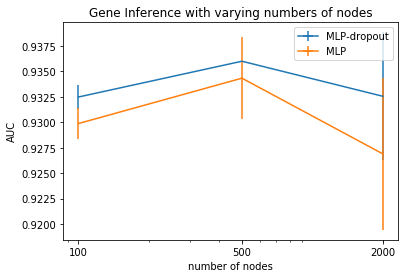

In [120]:
%matplotlib inline
for model in results["df"]["model"].unique():
    q = results["df"][results["df"].train_size==500].groupby(['model','num_genes'])['auc']
    index = q.mean()[model].index
    mean = q.mean()[model]
    stderr = q.std()[model]/np.sqrt(q.count()[model])
    plt.errorbar(index, mean,label=model, xerr=0, yerr=stderr)

plt.title("Gene Inference with varying numbers of nodes")
plt.ylabel("AUC")
plt.xlabel("number of nodes")
plt.xscale("log")
plt.xticks(sorted(results["df"]["num_genes"].unique()))
formatter = matplotlib.ticker.ScalarFormatter()
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend();

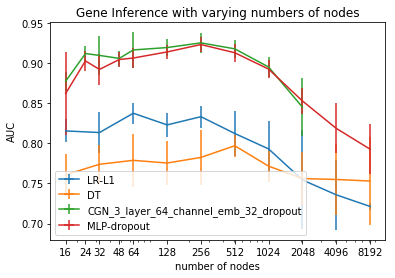

In [29]:
%matplotlib inline
for model in results["df"]["model"].unique():
    index = results["df"].groupby(['model','num_genes'])['auc'].mean()[model].index
    mean = results["df"].groupby(['model','num_genes'])['auc'].mean()[model]
    stderr = results["df"].groupby(['model','num_genes'])['auc'].std()[model]
    plt.errorbar(index, mean,label=model, xerr=0, yerr=stderr)

plt.title("Gene Inference with varying numbers of nodes")
plt.ylabel("AUC")
plt.xlabel("number of nodes")
plt.xscale("log")
plt.xticks(sorted(results["df"]["num_genes"].unique()))
formatter = matplotlib.ticker.ScalarFormatter()
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend();

In [ ]:
#results_df = pd.DataFrame(columns=['model', 'num_genes', 'gene_name', 'auc', 'std'])
#results_df = results_df.append(data=pd.DataFrame(pd.DataFrame(data={'model':"LR", 'num_genes': 10.0, 'gene_name': "RPL5", 'auc':0.57, 'std': 0.01}, index=[0]))
len(["LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout"])
len([10.0, 10.0, 10.0, 10.0, 510.0, 510.0, 510.0, 510.0, 1010.0, 1010.0, 1010.0, 1010.0, 1510.0, 1510.0, 1510.0, 1510.0, 2010.0, 2010.0, 2010.0, 2010.0, 2510.0, 2510.0, 2510.0, 2510.0, 3010.0, 3010.0, 3010.0, 3010.0])
len([0.57, 0.56, 0.55, 0.64, 0.81, 0.83, .79, .94, .81, .80, .78, .94, .80, .74, .77, .93, .78, .79, .78, .92, .77, .77, .76, .92, .76, .71, .76, .92])
len([0.01, 0.04, 0.03, 0.01, 0.02, 0.01, 0.03, 0.00, 0.01, 0.03, 0.02, 0.01, 0.03, 0.12, 0.02, 0.00, 0.03, 0.02, 0.03, 0.01, 0.02, 0.05, 0.04, 0.01, 0.02 ,0.11, 0.02, 0.00])
results_df = pd.DataFrame(data={'model':["LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout"],
                   'num_genes': [10.0, 10.0, 10.0, 10.0, 510.0, 510.0, 510.0, 510.0, 1010.0, 1010.0, 1010.0, 1010.0, 1510.0, 1510.0, 1510.0, 1510.0, 2010.0, 2010.0, 2010.0, 2010.0, 2510.0, 2510.0, 2510.0, 2510.0, 3010.0, 3010.0, 3010.0, 3010.0],
#                  'gene_name': ["RPL5", "RPL5"],
                   'auc': [0.57, 0.56, 0.55, 0.64, 0.81, 0.83, .79, .94, .81, .80, .78, .94, .80, .74, .77, .93, .78, .79, .78, .92, .77, .77, .76, .92, .76, .71, .76, .92],
                   'std': [0.01, 0.04, 0.03, 0.01, 0.02, 0.01, 0.03, 0.00, 0.01, 0.03, 0.02, 0.01, 0.03, 0.12, 0.02, 0.00, 0.03, 0.02, 0.03, 0.01, 0.02, 0.05, 0.04, 0.01, 0.02 ,0.11, 0.02, 0.00]}, index=range(0, 28))
plt.figure()
titles = []
for model in [
    {'key': 'LR', 'method': lr},
    {'key': 'MLP', 'method': mlp},
    {'key': 'Decision Tree', 'method': decision_tree},
    {'key': 'CGN_3_layer_64_channel_emb_32_dropout', 'method': cgn_loop, 'num_channel': 64, 'num_layer': 3, 'add_emb': 32, 'use_gate': False, 'dropout': True, 'cuda': True},
    ]:
    temp_results = results_df.loc[results_df['model'] == model['key']].reset_index(drop=True)
    lines.append(plt.errorbar(temp_results.index, temp_results['auc'], xerr=0, yerr=temp_results['std'])[0])
    titles.append(model['key'])
    plt.xticks(list(temp_results.index), temp_results['num_genes'], rotation=70)
width = 0.2
plt.title("Inferring the value of RPL5 with varying numbers of genes")
plt.ylabel("AUC")
plt.xlabel("# genes")
plt.legend(lines, titles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)


In [ ]:
# results of adding Nodes
plt.figure()

#full_results.loc[full_results['samples'] == 100]

line1 = plt.errorbar(lr_results.index, lr_results['auc'], xerr=0, yerr=lr_results['std'])
line2 = plt.errorbar(cgn_results.index, cgn_results['auc'], xerr=0, yerr=cgn_results['std'])

width = 0.2
plt.xticks(list(lr_results.iloc[::5, :].index), lr_results.iloc[::5, :]['num_genes'], rotation=70)
plt.title("Gene Inference with varying numbers of nodes")
plt.ylabel("AUC")
plt.xlabel("number of nodes")
plt.legend((line1[0], line2[0]), ('LR', "CGN"), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

In [ ]:
# Predict a gene from a growing number of Nodes
lr_results = pd.DataFrame([])
mlp_results = pd.DataFrame([])
cgn_results = pd.DataFrame([])
gene = "RPL5"
max_samples = 200
reload(data)
reload(models)
tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')

for num_samples in range(10, max_samples, 20):
    lr_row = infer_gene(lr, tcgatissue, "RPL5", train_size=num_samples, test_size=200, trials=3, penalty=True)
    lr_results = lr_results.append(lr_row).reset_index(drop=True)
    lr_results.loc[lr_results.index[-1], 'num_samples'] = num_samples
    cgn_row = infer_gene(cgn, tcgatissue, "RPL5", train_size=num_samples, test_size=200, trials=3, penalty=True)
    cgn_results = cgn_results.append(cgn_row).reset_index(drop=True)
    cgn_results.loc[lr_results.index[-1], 'num_samples'] = num_samples
    print num_genes
    print cgn_results
    print lr_results

In [ ]:
# results of adding Nodes
plt.figure()

#full_results.loc[full_results['samples'] == 100]

line1 = plt.errorbar(lr_results.index, lr_results['auc'], xerr=0, yerr=lr_results['std'])
line2 = plt.errorbar(cgn_results.index, cgn_results['auc'], xerr=0, yerr=cgn_results['std'])

width = 0.2
plt.xticks(list(lr_results.iloc[::5, :].index), lr_results.iloc[::5, :]['num_samples'], rotation=70)
plt.title("Gene Inference with varying numbers of samples")
plt.ylabel("AUC")
plt.xlabel("number of samples")
plt.legend((line1[0], line2[0]), ('LR', "CGN"), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)